In [9]:
import pandas as pd
import hockey_rink as hr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math

In [13]:
df = pd.read_csv('../data/CleanData/2_Drittel_151_153.csv')

In [14]:
df.head()

,Unnamed: 0,Period,MatchClock,Timestamp,EventType,TeamStrengthType,TeamStrength,HomeGoalieOnIce,AwayGoalieOnIce,EventPosition,...,StartPlayerDirection3,StartPlayerDirection4,StartPlayerDirection5,StartPlayerDirection6,StartPlayerDirection7,StartPlayerDirection8,StartPlayerDirection9,StartPlayerDirection10,StartPlayerDirection11,StartPlayerDirection12
0,1637,2,151,1704024703000,PuckControl,FullStrength,5v5,True,True,NeutralZone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1638,2,151,1704024703400,Pass,FullStrength,5v5,True,True,NeutralZone,...,"-0.834,-0.551","0.269,0.963","-0.999,0.042","0.88,0.474","-0.85,-0.527","-0.771,-0.637","-0.343,0.939","-0.999,0.035","-0.913,-0.408","-0.696,-0.718"
2,1639,2,151,1704024703420,PuckControl,FullStrength,5v5,True,True,NeutralZone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1640,2,152,1704024703960,BluelineCrossing,FullStrength,5v5,True,True,NeutralZone,...,"-0.778,-0.628","-0.245,0.969","-1,-0.028","0.516,0.857","-0.831,-0.557","-0.999,-0.048","-0.385,0.923","-0.85,-0.527","-0.805,-0.594","-0.847,-0.531"
4,1641,2,152,1704024704220,PuckControl,FullStrength,5v5,True,True,HomeTeamZone,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# each row has a column EventStartCoordinate and EventEndCoordinate which if applicable, contains the x and y coordinates of the event.
# these columns need to be split into two columns, one for x and one for y
df[['EventStartX', 'EventStartY']] = df['EventStartCoordinate'].str.split(',', expand=True)
df[['EventEndX', 'EventEndY']] = df['EventEndCoordinate'].str.split(',', expand=True)

In [17]:
# convert the columns to numeric
df['EventStartX'] = pd.to_numeric(df['EventStartX'])
df['EventStartY'] = pd.to_numeric(df['EventStartY'])
df['EventEndX'] = pd.to_numeric(df['EventEndX'])
df['EventEndY'] = pd.to_numeric(df['EventEndY'])


In [18]:
# create a rink object
rink = hr.IIHFRink()

In [19]:
# convert the x and y coordinates to the rink coordinates using the rink.convert method
# the coordinates of the board in the hockey_rink package for the IIHF rink are length 197 and width 98.4
df['RinkX'], df['RinkY'] = rink.convert_xy(df['EventStartX'] * 3.2833 , df['EventStartY']*3.28)


In [32]:
shots = df[df['EventType'] == 'Shot']

In [21]:
passE = df[df['EventType'] == 'Pass']

In [22]:
crossings = df[df['EventType'] == 'BluelineCrossing']

In [44]:

def distance_to_enemy_goal(X,Y,Team):
    
    rightGoal = [26.0,0.0]
    leftGoal = [-26.0, 0.0]
    
    if Team == 'Home':
        enemygoal = rightGoal
    
    if Team == 'Away':
        enemygoal = leftGoal
        
    return math.sqrt((enemygoal[0] - (X/ 3.2833))**2 + (enemygoal[1] - (Y/ 3.2833))**2)

def mean_distance_to_opponents(X,Y,Team, df: pd.DataFrame):
    
    distances_to_opponents = []
    main_player_team = ""
    opponent_team = ""
    
    if Team == 'Home':
        main_player_team = "Home"
        opponent_team = "Away"
    elif Team == 'Away':
        main_player_team = "Away"
        opponent_team = "Home"   
    else:
        print("Error: The team is neither home nor away.")
        
    for i in range(1, 12):
        if i == 1 or i == 7:
            continue

        coords_primary = [X,Y]
        float_coords_primary = [float(coord) for coord in coords_primary]
        
        if df[f'StartPlayerTeam{i}'] == opponent_team: 
            
            if type(df[f'StartPlayerCoordinates{i}']) == str:
                coords_opponent = df[f'StartPlayerCoordinates{i}'].split(',')

            elif type(df[f'StartPlayerCoordinates{i}']) == tuple:
                coords_opponent = df[f'StartPlayerCoordinates{i}']
                
            value = math.sqrt(((float_coords_primary[0]/ 3.2833) - float(coords_opponent[0])) ** 2 + ((float_coords_primary[1]/ 3.2833) - float(coords_opponent[1])) ** 2)
            distances_to_opponents.append(value)

    return sum(distances_to_opponents)/len(distances_to_opponents)


def plot_event(event):
    
    
    rink = hr.IIHFRink()
    
    rightGoal = [26.0 * 3.2833,0.0]
    leftGoal = [-26.0 * 3.2833, 0.0]
 

    if event['EventPrimaryTeam'] == "Home":
        enemygoal = rightGoal
        Team = 'Home'
        goal_coords = pd.DataFrame({'x': [26.0 * 3.2833], 'y': [0 * 3.28]})
    
    elif event['EventPrimaryTeam'] == "Away":
        enemygoal = leftGoal
        Team = 'Away'
        goal_coords = pd.DataFrame({'x': [-26.0 * 3.2833], 'y': [0 * 3.28]})
        
    else:
        print("Error: The team is neither home nor away.")
    
    playerPos = [event['RinkX'], event['RinkY']]
    
    radius = mean_distance_to_opponents(playerPos[0],playerPos[1], Team, event)
    
    distancetogoal = distance_to_enemy_goal(playerPos[0],playerPos[1], Team)
    
    print(f'Distance to goal: {distancetogoal}')
    print(f'Mean distance to opponents: {radius}')
    
    fig, ax = plt.subplots(figsize=(18, 8))
    # Hockeyfeld zeichnen
    rink.draw(ax=ax)
    
    # Formen zeichnen
    circle = plt.Circle((playerPos[0], playerPos[1]), radius, facecolor='#eeff41', fill=True, edgecolor='black')
    ax.add_patch(circle)
    
    line = plt.Line2D([playerPos[0], enemygoal[0]], [playerPos[1], enemygoal[1]], color='black', linewidth=2.5)

    ax.add_line(line)
    
    # Aktuelle Zeile plotten
    sns.scatterplot(x='RinkX', y='RinkY', s=100, edgecolor='white', data=pd.DataFrame([event]), color='darkgray', ax=ax)
    sns.scatterplot(x='x', y='y', data=goal_coords, color='purple', s=100, legend=False, ax=ax)
    

    
    plt.show()

Distance to goal: 24.01597068517239
Mean distance to opponents: 9.320701408900504


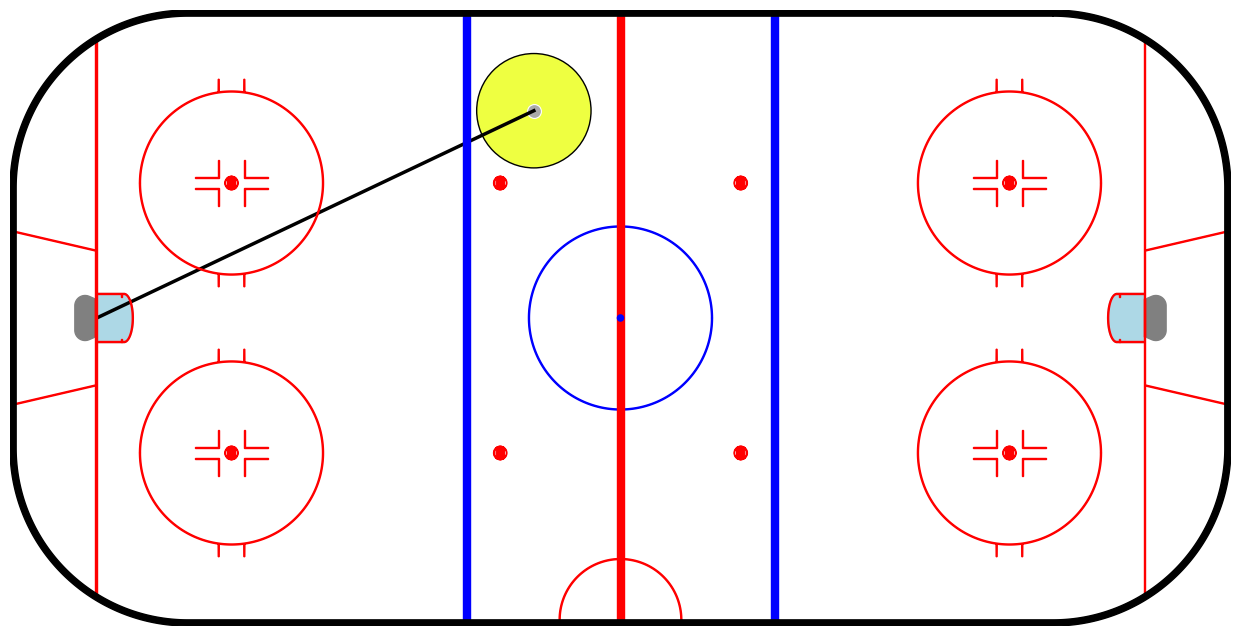

In [45]:
plot_event(passE.iloc[0])


In [42]:
dddd= df[df['Timestamp'] == 1704024704220]
dddd

,Unnamed: 0,Period,MatchClock,Timestamp,EventType,TeamStrengthType,TeamStrength,HomeGoalieOnIce,AwayGoalieOnIce,EventPosition,...,StartPlayerDirection9,StartPlayerDirection10,StartPlayerDirection11,StartPlayerDirection12,EventStartX,EventStartY,EventEndX,EventEndY,RinkX,RinkY
4,1641,2,152,1704024704220,PuckControl,FullStrength,5v5,True,True,HomeTeamZone,...,NaN,NaN,NaN,NaN,-8.6,6.9,-13.4,6.4,-28.23638,22.632


Distance to goal: 18.71561764339297
Mean distance to opponents: 9.249090610650843


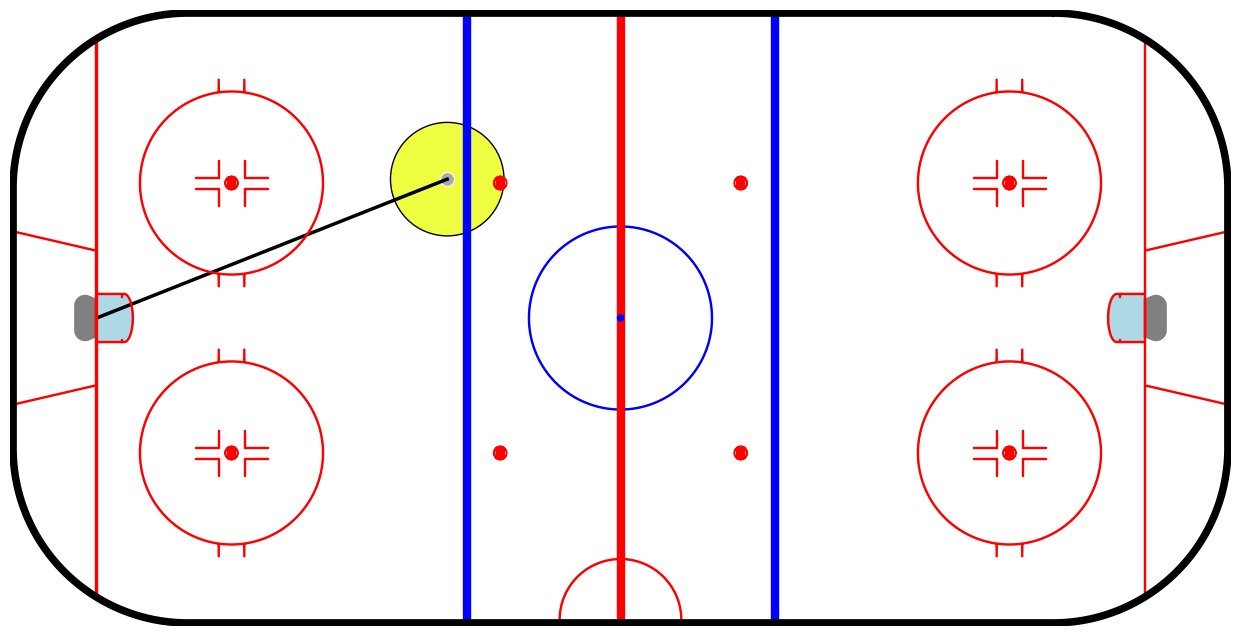

In [46]:
plot_event(dddd.iloc[0])

In [34]:
shots

,Unnamed: 0,Period,MatchClock,Timestamp,EventType,TeamStrengthType,TeamStrength,HomeGoalieOnIce,AwayGoalieOnIce,EventPosition,...,StartPlayerDirection9,StartPlayerDirection10,StartPlayerDirection11,StartPlayerDirection12,EventStartX,EventStartY,EventEndX,EventEndY,RinkX,RinkY
5,1642,2,153,1704024705320,Shot,FullStrength,5v5,True,True,HomeTeamZone,...,NaN,NaN,NaN,NaN,-13.6,5.2,NaN,NaN,-44.65288,17.056


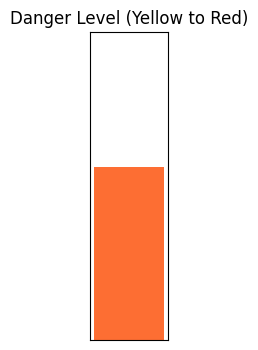

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_combined_score(distance_to_goal, mean_distance_to_opponents):
    # Extremwerte für die Normierung
    min_distance_to_goal = 1
    max_distance_to_goal = 58
    min_mean_distance_to_opponents = 1
    max_mean_distance_to_opponents = 20
    
    # Normierung der Werte auf den Bereich [0, 1]
    norm_distance_to_goal = (distance_to_goal - min_distance_to_goal) / (max_distance_to_goal - min_distance_to_goal)
    norm_mean_distance_to_opponents = (mean_distance_to_opponents - min_mean_distance_to_opponents) / (max_mean_distance_to_opponents - min_mean_distance_to_opponents)
    
    # Distance to goal invertieren (kleiner ist besser -> größer ist gefährlicher)
    inverted_norm_distance_to_goal = 1 - norm_distance_to_goal
    
    # Kombinierter Score als Durchschnitt (50/50 Gewichtung)
    combined_score = (inverted_norm_distance_to_goal + norm_mean_distance_to_opponents) / 2
    
    return combined_score

def plot_danger_level_bar(distance_to_goal, mean_distance_to_opponents):
    # Berechne den kombinierten Score
    combined_score = calculate_combined_score(distance_to_goal, mean_distance_to_opponents)
    
    # Erstelle den Farbverlauf von Gelb zu Rot basierend auf dem kombinierten Score
    cmap = plt.get_cmap("YlOrRd")
    color = cmap(combined_score)
    
    # Visualisierung des Balkens mit der entsprechenden Gefährlichkeit
    fig, ax = plt.subplots(figsize=(1, 4))  # Schlankes Diagramm für einen vertikalen Balken
    
    # Balkenhöhe (Gefährlichkeitsgrad) wird basierend auf dem Score angepasst
    bar_height = combined_score  # Die Höhe des Balkens entspricht dem kombinierten Score
    
    # Zeichne den Balken mit reduzierter Breite (2/3 weniger)
    bar_width = 0.51  # Schmale Breite
    ax.bar(0.5, bar_height, color=color, width=bar_width)
    
    # Beschriftung hinzufügen
    #ax.text(0.5, bar_height + 0.05, f"{combined_score:.2f}", ha='center', fontsize=12, color='black')
    
    # Diagramm anpassen
    ax.set_ylim(0, 1)  # Skala von 0 bis 1 (kombinierter Score normiert)
    ax.set_xticks([])  # Keine X-Achsen-Beschriftung
    ax.set_yticks([])  # Keine Y-Achsen-Beschriftung
    plt.title("Danger Level (Yellow to Red)")
    
    # Zeige die Grafik
    plt.show()

# Beispielwerte
distance_to_goal = 18.71561764339297
mean_distance_to_opponents = 9.249090610650843

# Plotten
plot_danger_level_bar(distance_to_goal, mean_distance_to_opponents)


In [ ]:
Distance to goal: 18.71561764339297
Mean distance to opponents: 9.249090610650843